## Общее описание:
Есть данные о такси-компании (uber), которая хочет изучить отток водителей и посмотреть, какие есть различия между водителями, которые покидают сервис, и которые остаются. Нужно сформулировать и протестировать гипотезы, выделить группы водителей, которые наиболее подвержены "оттоку". На основе результатов сделать выводы о том, что можно улучшить в сервисе, чтобы в дальнейшем внести изменения (и после – провести A/B тест и выяснить, стало ли лучше).

### Описание данных

- `city` – город
- `phone` – основное устройство, которое использует водитель
- `signup_date` – дата регистрации аккаунта (`YYYYMMDD`)
- `last_trip_date` – дата последней поездки (`YYYYMMDD`)
- `avg_dist` – среднее расстояние (в милях) за поездку в первые 30 дней после регистрации
- `avg_rating_by_driver` – средняя оценка поездок водителем
- `avg_rating_of_driver` – средняя оценка поездок водителя
- `surge_pct` – процент поездок, совершенных с множителем > 1 (кажется когда большая загруженность и тд)
- `avg_surge` – средний множитель всплеска за все поездки этого водителя
- `trips_in_first_30_days` – количество поездок, которые совершил водитель в первые 30 дней после регистрации
- `luxury_car_user` – TRUE, если пользователь в первые 30 дней использовал премиум-автомобиль
- `weekday_pct` – процент поездок пользователя, совершенных в будние дни


### План

1. **Сначала сделаем небольшой препроцессинг:**
    - Посмотрим на данные
2. **Далее сформулируем гипотезы, исходя из общей задачи:**
    - Сформулируем предположения, которые будем тестировать
    - Создадим лейбл churn/not_churn
    - Построим графики
    - **Поинт:** только по графикам выводы делать – bad practice, хорошо подкреплять стат. тестами (и стат. тесты есть не только в A/B)
3. **Тестируем гипотезы:**
     - Выбираем гипотезу
     - Выбираем подходящий тест
     - Тестируем
4. **Подводим итоги:**
    - Сформулировать выводы и суммаризировать всё что было
    - Какие действия нужно предпринять разработчикам/бизнесу, чтобы стало лучше? Как можно будет позже провести A/B тестирование? (починить android приложение, возможно таргетить и мотивировать не очень активных водителей, улучшить программу лояльности и бонусов для водителей и тд и тп)

## 1: загружаем
Еще раз список переменных:

- `city` – город
- `phone` – основное устройство, которое использует водитель
- `signup_date` – дата регистрации аккаунта (`YYYYMMDD`)
- `last_trip_date` – дата последней поездки (`YYYYMMDD`)
- `avg_dist` – среднее расстояние (в милях) за поездку в первые 30 дней после регистрации
- `avg_rating_by_driver` – средняя оценка поездок водителем
- `avg_rating_of_driver` – средняя оценка поездок водителя
- `surge_pct` – процент поездок, совершенных с множителем > 1
- `avg_surge` – средний множитель всплеска за все поездки этого водителя
- `trips_in_first_30_days` – количество поездок, которые совершил водитель в первые 30 дней после регистрации
- `luxury_car_user` – TRUE, если пользователь в первые 30 дней использовал премиум-автомобиль
- `weekday_pct` – процент поездок пользователя, совершенных в будние дни

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

In [ ]:
!pip install scikit_posthocs -q

In [ ]:
from scipy.stats import chi2_contingency, chi2, mannwhitneyu, shapiro, kruskal
import statsmodels.api as sa
import scikit_posthocs as sp  # sp.posthoc_dunn() для непараметрического аналога anova

In [ ]:
sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")

In [ ]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/406362/churn.csv')

In [ ]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [ ]:
df.shape

(50000, 12)

In [ ]:
df.last_trip_date = pd.to_datetime(df.last_trip_date)
df.signup_date = pd.to_datetime(df.signup_date)

In [ ]:
df.last_trip_date.max()

Timestamp('2014-07-01 00:00:00')

In [ ]:
df['days_since_last_trip'] = df.last_trip_date.max() - df.last_trip_date

In [ ]:
df['days_since_last_trip']

0        14 days
1        57 days
2       175 days
3         2 days
4       108 days
          ...   
49995    26 days
49996   157 days
49997    40 days
49998   167 days
49999    72 days
Name: days_since_last_trip, Length: 50000, dtype: timedelta64[ns]

Преобразуем в int:

In [ ]:
df['days_since_last_trip'] = df['days_since_last_trip'].dt.days

In [ ]:
df['days_since_last_trip']

0         14
1         57
2        175
3          2
4        108
        ... 
49995     26
49996    157
49997     40
49998    167
49999     72
Name: days_since_last_trip, Length: 50000, dtype: int64

In [ ]:
df['churn'] = df.days_since_last_trip.apply(lambda x: 'churn' if x > 30 else 'not_churn')
df[['days_since_last_trip', 'churn']]

,days_since_last_trip,churn
0,14,not_churn
1,57,churn
2,175,churn
3,2,not_churn
4,108,churn
...,...,...
49995,26,not_churn
49996,157,churn
49997,40,churn
49998,167,churn


## Step 2
Проверьте, есть ли различия в размерах оттока клиентов в разных городах (churn, city)

In [ ]:
pd.crosstab(df['churn'], df['city'])

city,Astapor,King's Landing,Winterfell
churn,,,
churn,12306,3767,15123
not_churn,4228,6363,8213


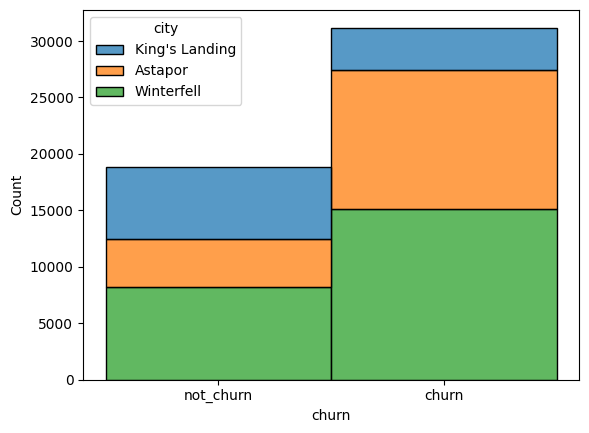

In [ ]:
sns.histplot(df[['churn', 'city']].dropna(), x='churn', multiple="stack", hue='city');

In [ ]:
chi2_contingency(pd.crosstab(df['churn'], df['city']))

Chi2ContingencyResult(statistic=3821.5510225559633, pvalue=0.0, dof=2, expected_freq=array([[10315.89328,  6320.3096 , 14559.79712],
       [ 6218.10672,  3809.6904 ,  8776.20288]]))

## Step 3
Есть ли разница в активности в первые 30 дней с момента регистрации между водителями из разных городов? (city, trips_in_first_30_days)

Проверим распределения на нормальность (любым нравящимся вам способом):

In [ ]:
shapiro(df['trips_in_first_30_days'])

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.5649271011352539, pvalue=0.0)

<Axes: xlabel='trips_in_first_30_days', ylabel='Count'>

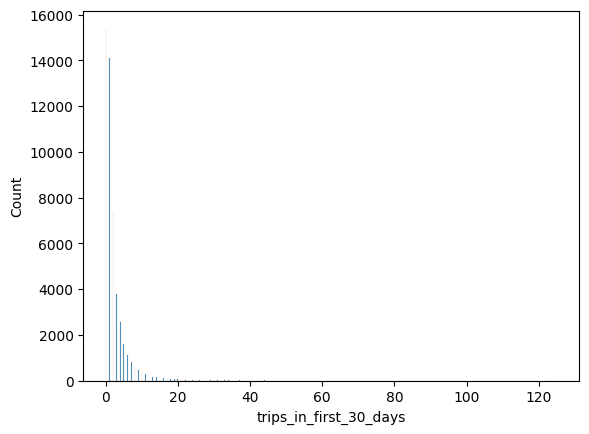

In [ ]:
sns.histplot(df['trips_in_first_30_days'])

## Step 4
Есть ли разница в активности в первые 30 дней с момента регистрации между водителями из разных городов? (city, trips_in_first_30_days)

Обнаружены ли статистически значимые различия?

In [ ]:
pd.crosstab(df['trips_in_first_30_days'], df['city']).head()

city,Astapor,King's Landing,Winterfell
trips_in_first_30_days,,,
0,5333,3532,6525
1,5143,2270,6695
2,2445,1466,3491
3,1153,764,1871
4,738,551,1273


<Axes: xlabel='trips_in_first_30_days', ylabel='Count'>

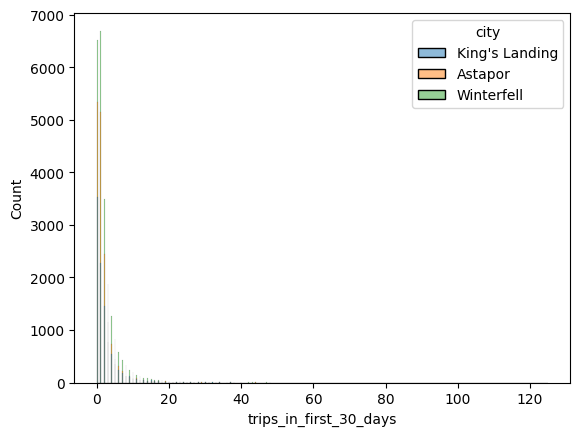

In [ ]:
sns.histplot(data=df, x='trips_in_first_30_days', hue='city')

In [ ]:
astapor_city = df[df['city'] == 'Astapor']['trips_in_first_30_days']
kings_city = df[df['city'] == "King's Landing"]['trips_in_first_30_days']
winterfell_city = df[df['city'] == 'Winterfell']['trips_in_first_30_days']

In [ ]:
kruskal(winterfell_city, astapor_city, kings_city)

KruskalResult(statistic=221.32105325320535, pvalue=8.724567791804361e-49)

## Step 5
Может ли отток быть связан с активностью в первые 30 дней после регистрации? (churn, trips_in_first_30_days)

In [ ]:
churn = df[df['churn'] == 'churn']['trips_in_first_30_days']
not_churn = df[df['churn'] == 'not_churn']['trips_in_first_30_days']

In [ ]:
mannwhitneyu(churn, not_churn)

MannwhitneyuResult(statistic=234767452.0, pvalue=0.0)

<Axes: xlabel='churn', ylabel='trips_in_first_30_days'>

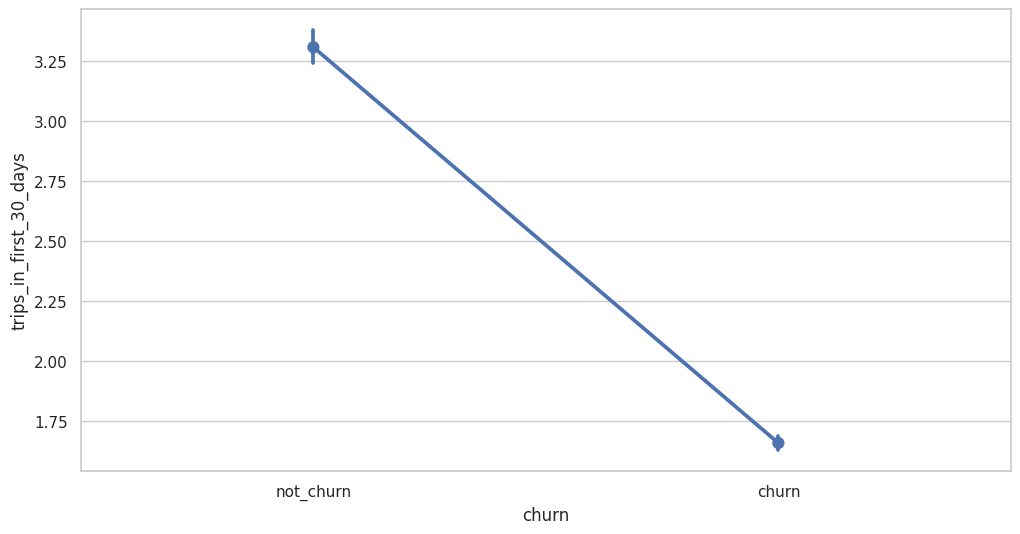

In [ ]:
sns.pointplot(data=df, x='churn', y='trips_in_first_30_days')